In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png
/kaggle/input/sms-spam-collection-dataset/spam.csv


# Importing Libraries

In [2]:
import plotly.express as px
import re
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import keras

from PIL import Image
from wordcloud import WordCloud
from plotly import graph_objs as go
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [3]:
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

# Importing Data

In [4]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA

In [6]:
df['words_count'] = df['message'].apply(lambda x: len(x.split(' ')))
df['message_len'] = df['message'].apply(len)
df.head()

,target,message,words_count,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111
1,ham,Ok lar... Joking wif u oni...,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155
3,ham,U dun say so early hor... U c already then say...,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61


In [7]:
print(max(df["words_count"]))
print(max(df["message_len"]))

171
910


In [8]:
df.describe()

,words_count,message_len
count,5572.000000,5572.000000
mean,15.606784,80.118808
std,11.422465,59.690841
min,1.000000,2.000000
25%,7.000000,36.000000
50%,12.000000,61.000000
75%,23.000000,121.000000
max,171.000000,910.000000


In [9]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [10]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [11]:
ham_df = df[df['target'] == 'ham']['words_count'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['words_count'].value_counts().sort_index()

In [12]:
print(ham_df.count())
print(ham_df.max())

82
412


In [13]:
print(spam_df.count())
print(spam_df.max())

34
85


In [14]:
concat = pd.concat([ham_df,spam_df], axis=1)
concat

,count,count
words_count,,
1,40,NaN
2,38,2.0
3,76,1.0
4,189,1.0
5,348,3.0
...,...,...
119,1,NaN
121,1,NaN
125,2,NaN


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = ham_df.index,
    y = ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color = primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

# Data Pre-Processing

## Cleaning

In [16]:
def clean_text(text):

    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','c']
    text = str(text).lower()
    text = re.sub('\[.*?\]','', text)
    text = re.sub('https?://\S+|www\.\S+', '',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    text = ' '.join(word for word in text.split(' ') if word not in STOPWORDS)
    return text

In [17]:
df['clean_message'] = df['message'].apply(clean_text)
df['clean_message_words_count'] = df['clean_message'].apply(lambda x:len(x.split(' ')))
df['clean_message_len'] = df['clean_message'].apply(len) 
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazy available bugis n great ...,16,82
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joking wif oni,5,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entry wkly comp win fa cup final tkts m...,23,103
3,ham,U dun say so early hor... U c already then say...,11,49,dun say early hor already say,6,29
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goes usf lives around though,7,38


In [18]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
df['clean_message'] = df['clean_message'].apply(stemm_text)
df['stem_clean_message_len'] = df['clean_message'].apply(len)
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len,stem_clean_message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazi avail bugi n great world...,16,82,76
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joke wif oni,5,21,19
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entri wkli comp win fa cup final tkts m...,23,103,101
3,ham,U dun say so early hor... U c already then say...,11,49,dun say earli hor alreadi say,6,29,29
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goe usf live around though,7,38,36


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])
df['encoded_target'] = le.transform(df['target'])
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len,stem_clean_message_len,encoded_target
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazi avail bugi n great world...,16,82,76,0
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joke wif oni,5,21,19,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entri wkli comp win fa cup final tkts m...,23,103,101,1
3,ham,U dun say so early hor... U c already then say...,11,49,dun say earli hor alreadi say,6,29,29,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goe usf live around though,7,38,36,0


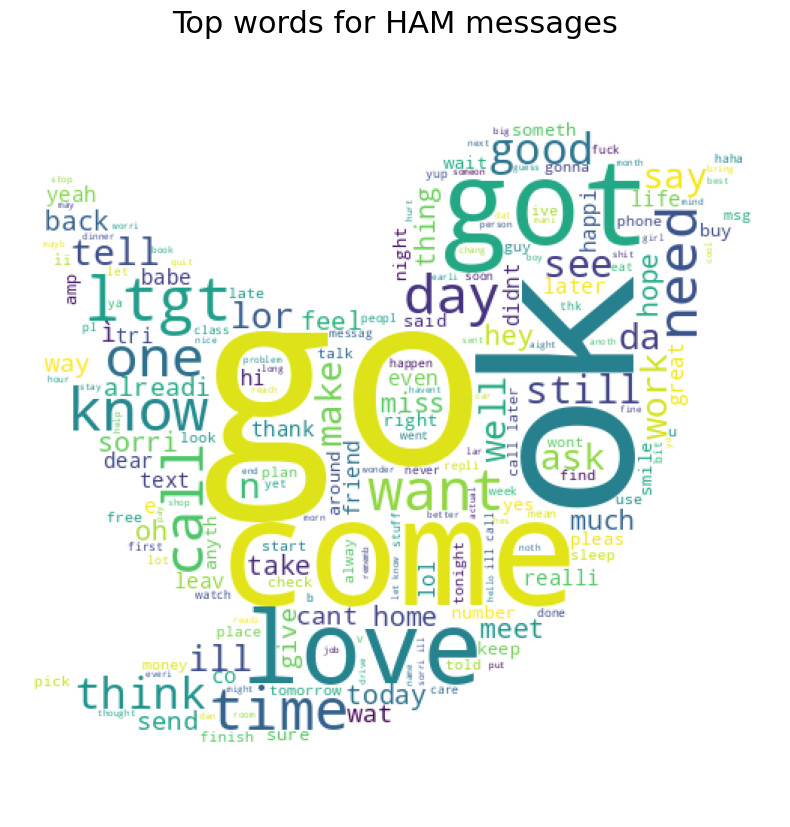

In [21]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white',
    max_words = 200,
    mask=twitter_mask
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

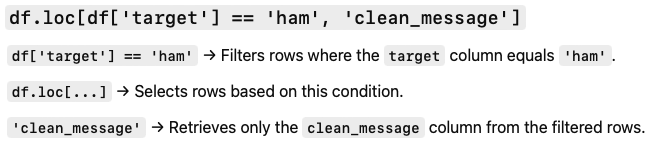

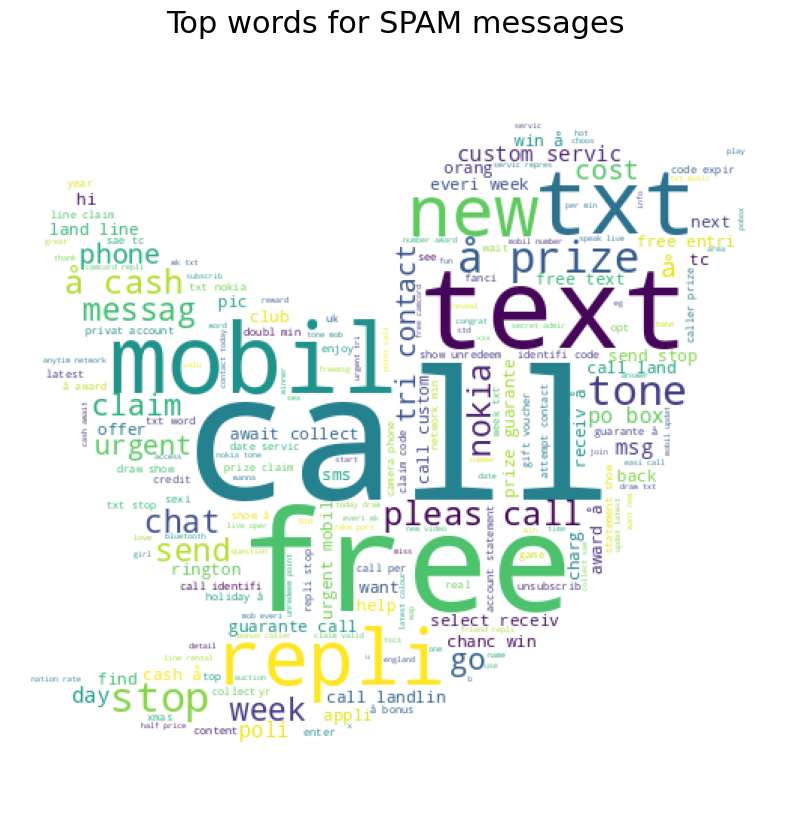

In [22]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [23]:
x = df['clean_message']
y = df['encoded_target']

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

4179 4179
1393 1393


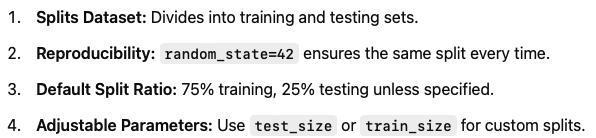

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [26]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5713 sparse matrix of type '<class 'numpy.float64'>'
	with 32001 stored elements in Compressed Sparse Row format>

In [28]:
texts = df['clean_message']
targets = df['encoded_target']

We need to perform tokenization - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [29]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6765

In [30]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence:len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)                                                            
train_padded_sentences

array([[   2, 3195,  274, ...,    0,    0,    0],
       [   6,  237,  530, ...,    0,    0,    0],
       [   7,  359,  589, ...,    0,    0,    0],
       ...,
       [6763, 1003, 6764, ...,    0,    0,    0],
       [ 137, 1253, 1608, ...,    0,    0,    0],
       [1994,  380,  169, ...,    0,    0,    0]], dtype=int32)

In [31]:
embedding_dictionary = dict()
embedding_dim = 100

with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embedding_dictionary[word] = vector_dimensions
# embedding_dictionary

In [32]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [33]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [34]:
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

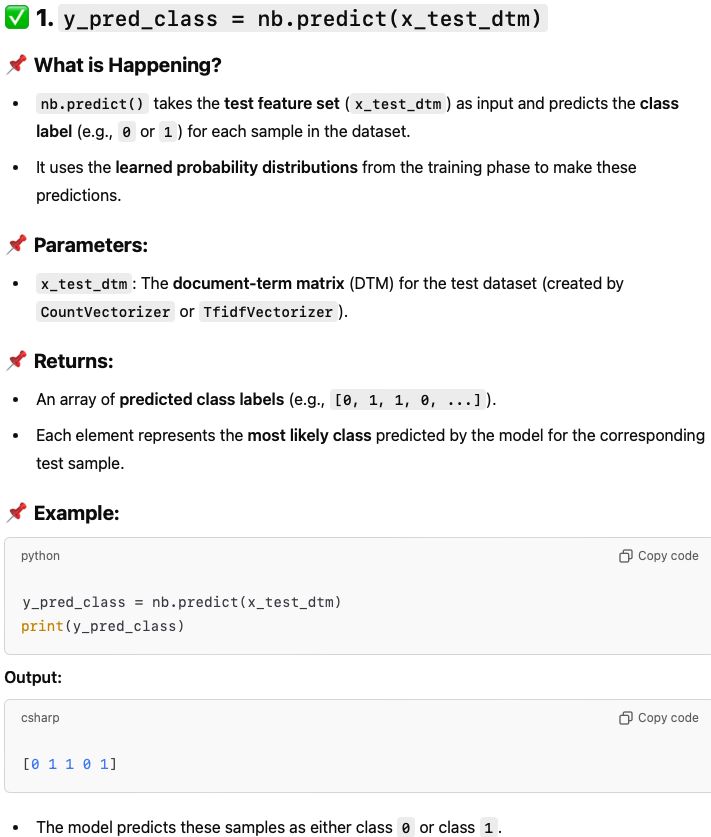

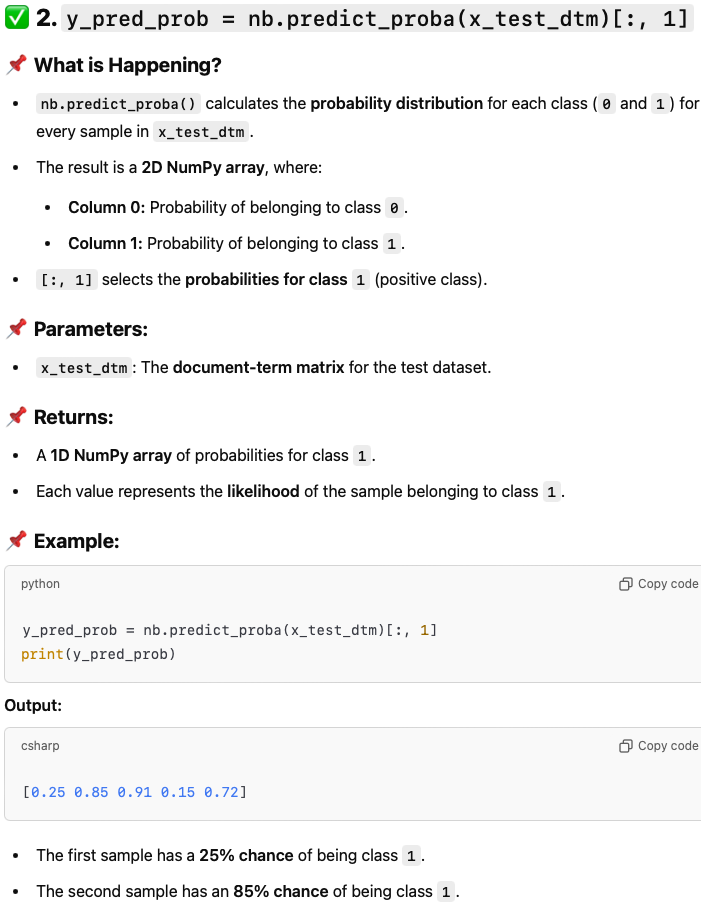

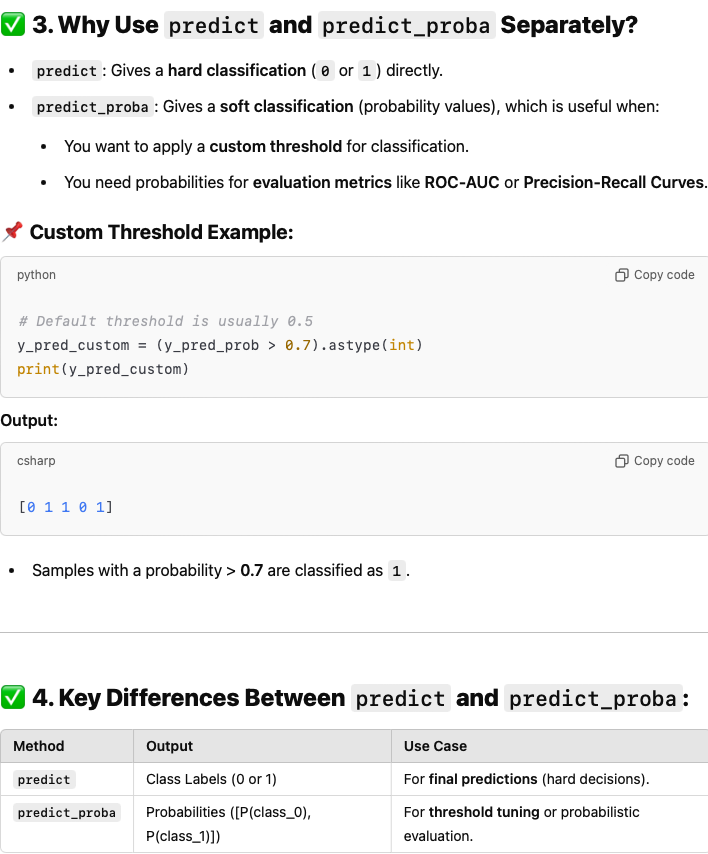

In [35]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.9784637473079684


In [36]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[1191,   11],
       [  19,  172]])

In [37]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [38]:
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

In [39]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9745973116359297

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

In [41]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9605168700646087


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    targets, 
    test_size=0.25
)

In [43]:
embedding_matrix.shape

(6765, 100)

In [44]:
def glove_lstm():
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix]))
    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         676,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 676,500 (2.58 MB)

 Trainable params: 676,500 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7817 - loss: 0.5124
Epoch 1: val_loss improved from inf to 0.34519, saving model to model.h5.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7823 - loss: 0.5111 - val_accuracy: 0.9454 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9347 - loss: 0.2011
Epoch 2: val_loss improved from 0.34519 to 0.13746, saving model to model.h5.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9348 - loss: 0.2008 - val_accuracy: 0.9620 - val_loss: 0.1375 - learning_rate: 0.0010
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9649 - loss: 0.1107
Epoch 3: val_loss improved from 0.13746 to 0.11966, saving model to model.h5.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9649 - loss: 0.1108 - val_accuracy: 0.9627 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.966

In [46]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

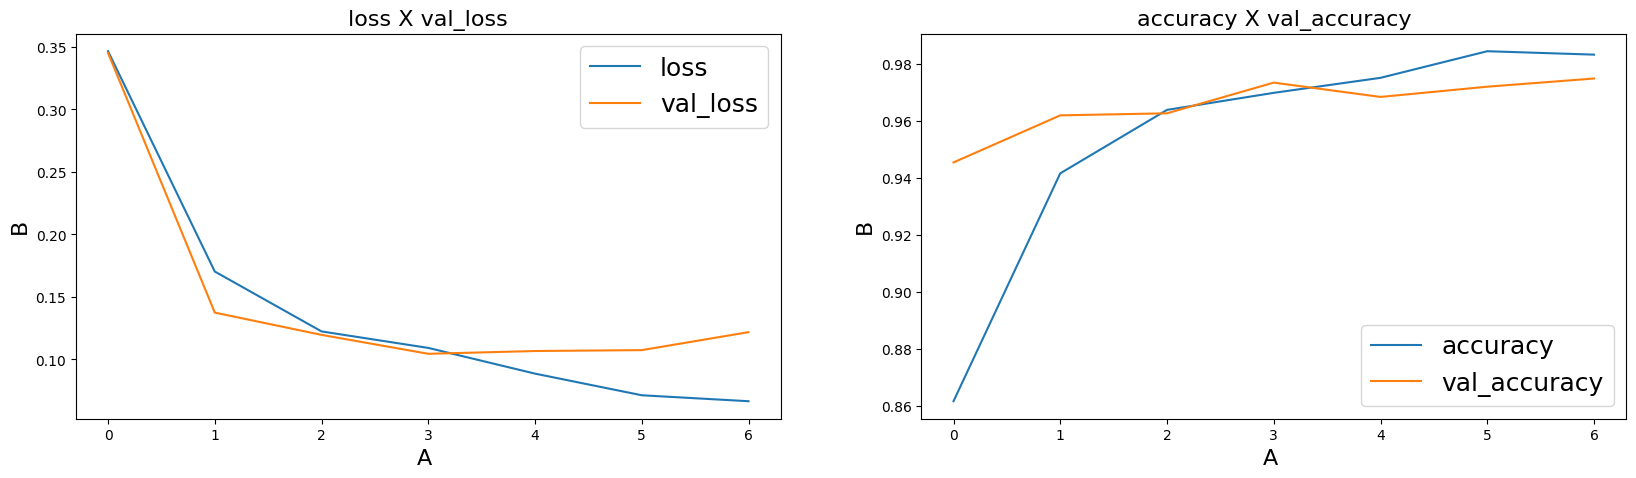

In [47]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [48]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
